# Grid-Search on: <br> &emsp;Document Vectors using Cosine Similarity + BON

In [1]:
from ensemble_gs import read_logs, get_vectors_for_ensemble
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from scipy.sparse import hstack
from scipy import sparse

import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm


Run the main grid-search experiment with ensemble_gs.py first before running this notebook !!!

!python ensemble_gs.py

In [2]:
# load test results
sns.set(font_scale=1.1, style="whitegrid")

with open('test_logs/dv+bon_logs.pkl', 'rb') as f:
    his = pickle.load(f)
    
df = read_logs(his)

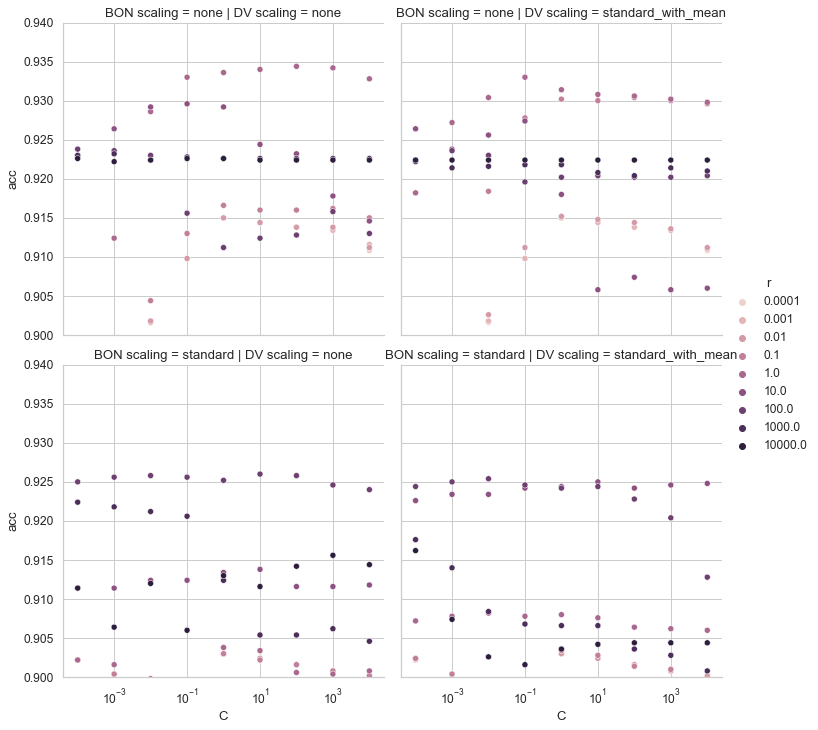

In [3]:
g = sns.relplot(x="C", y="acc", hue="r", col="DV scaling", row="BON scaling", data=df, hue_norm=LogNorm(1e-4, 1e4), legend="full")
g.set(xscale="log")
g.set(ylim=(0.9, 0.94))
g.savefig("figures/dv_bon_gs.jpg")

In [4]:
top = df.sort_values(by="acc", ascending=False).head(4).copy()
top

,C,r,acc,DV scaling,BON scaling
42,100.0,1.0,0.9344,none,none
43,1000.0,1.0,0.9342,none,none
41,10.0,1.0,0.9340,none,none
40,1.0,1.0,0.9336,none,none


In [5]:
os.chdir('files_root')
path_1gram = 'alldata-id_p1gram.txt'
path_3gram = "alldata-id_p3gram.txt"
path_embedding_train = 'train_vectors.txt'
path_embedding_test = 'test_vectors.txt'

bon_train, bon_test, emb_train, emb_test, y_train, y_test = get_vectors_for_ensemble(path_1gram, path_3gram, path_embedding_train, path_embedding_test, train_val_test=False)
os.chdir("..")

reading embeddings from train_vectors.txt
reading embeddings from test_vectors.txt


In [6]:
lr = LogisticRegression(solver="liblinear")
for i, a in top.iterrows():
    lr.set_params(C=a["C"])
    lr.fit(hstack([emb_train * a["r"], bon_train]), y_train)
    test_score = lr.score(hstack([emb_test * a["r"], bon_test]), y_test)
    top.loc[i, "test score"] = test_score

top    

,C,r,acc,DV scaling,BON scaling,test score
42,100.0,1.0,0.9344,none,none,0.93532
43,1000.0,1.0,0.9342,none,none,0.93424
41,10.0,1.0,0.9340,none,none,0.93684
40,1.0,1.0,0.9336,none,none,0.93684


In [7]:

lgcv = LogisticRegressionCV(Cs=np.logspace(-4, 4, 9), tol=0.001, solver='liblinear')
lgcv.fit(bon_train, y_train)
bon_test_score = lgcv.score(bon_test, y_test)

lgcv.fit(emb_train, y_train)
dv_test_score = lgcv.score(emb_test, y_test)
print("bon score:", bon_test_score)
print("dv score:", dv_test_score)

bon score: 0.91292
dv score: 0.93128


In [8]:
mag = []
mag.append({
    "name": "DV",
    "ndim": emb_train.shape[1],
    "mean norm": np.linalg.norm(emb_train, axis=-1).mean(),
    "mean norm avg": np.linalg.norm(emb_train, axis=-1).mean()/emb_train.shape[1],
})
mag.append({
    "name": "BON",
    "ndim": bon_train.shape[1],
    "mean norm": sparse.linalg.norm(bon_train, axis=-1).mean(),
    "mean norm avg":  sparse.linalg.norm(bon_train, axis=-1).mean()/bon_train.shape[1]
})
pd.DataFrame.from_records(mag, index="name")


,ndim,mean norm,mean norm avg
name,,,
DV,500,5.367556,0.010735
BON,5142829,16.521251,0.000003
